In [ ]:
#calculates monthly mean, median, and standard deviation of emodis and smodis for comparison
#calculates RMSE and correlation per UAI based on monthly means
#author: Sara Miller

!pip install --upgrade pip --quiet

# try to import packages needed
try:
  import ee
  import folium
  from ee.ee_exception import EEException
  
  from google.colab import auth
  from pydrive.auth import GoogleAuth
  from pydrive.drive import GoogleDrive
  from oauth2client.client import GoogleCredentials


# if it doesn't work, intstall the packages...
except ImportError:
  !pip install -q earthengine-api
  !pip install -q folium
  !pip install -q bokeh
  
  # ...then import
  import ee
  import folium
  from ee.ee_exception import EEException


# import Python packages for utility
import numpy as np
import pandas as pd
import math
import datetime
import scipy.stats as ss
from itertools import groupby
import geopandas as gpd
from shapely.geometry import shape
import matplotlib.pyplot as plt
from google.colab import files

     |████████████████████████████████| 1.5MB 9.2MB/s 
     |████████████████████████████████| 153 kB 7.6 MB/s 


/usr/local/lib/python2.7/dist-packages/folium/__init__.py:59: UserWarning: This version of folium is the last to support Python 2. Transition to Python 3 to be able to receive updates and fixes. Check out https://python3statement.org/ for more info.
  UserWarning


In [ ]:
# try to initialize Earth Engine session
try:
  ee.Initialize()

# if it doesn't work, then authorize an account for Earth Engine to connect to...
except EEException:
  !earthengine authenticate --quiet

  authCode = raw_input("Authorization code:")

  !earthengine authenticate --authorization-code=$authCode
  
  # ...then initialize session
  ee.Initialize()

W0720 17:31:42.387995 140325167216512 deprecation.py:323] From /usr/local/lib/python2.7/dist-packages/tensorflow_core/python/compat/v2_compat.py:88: disable_resource_variables (from tensorflow.python.ops.variable_scope) is deprecated and will be removed in a future version.
Instructions for updating:
non-resource variables are not supported in the long term
Running command using Cloud API.  Set --no-use_cloud_api to go back to using the API

Paste the following address into a web browser:

    https://accounts.google.com/o/oauth2/auth?code_challenge=C6dHwEwWAqy8DnzajGUma-GvTGvesBCk-TS4B47VfOk&client_id=517222506229-vsmmajv00ul0bs7p89v5m89qs8eb9359.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&response_type=code&code_challenge_method=S256&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fearthengine+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdevstorage.full_control

On the web page, please authorize access to your Earth Engine account and copy the authenticati

EEException: ignored

In [ ]:
import cv2 

smodis = ee.ImageCollection('projects/servir-e-sa/sMODIS')
slist = smodis.toList(smodis.size())

image_stack = np.empty((4899, 4453, 705))

area = ee.Geometry.Polygon([[32.91437661261091,-5.134507651454615],\
                            [42.09894692511091,-5.134507651454615],\
                            [42.09894692511091,6.053367953478971],\
                            [32.91437661261091,6.053367953478971],\
                            [32.91437661261091,-5.134507651454615]])

# export the latitude, longitude and array
def LatLonImg(img):
  #img = img.addBands(ee.Image.pixelLonLat())
 
  img = img.reduceRegion(reducer=ee.Reducer.toList(),\
                                        geometry=area,\
                                        maxPixels=1e13,\
                                        scale=10);
 
  data = np.array((ee.Array(img.get("result")).getInfo()))
  #lats = np.array((ee.Array(img.get("latitude")).getInfo()))
  #lons = np.array((ee.Array(img.get("longitude")).getInfo()))
  print(data)
  return data

collectionSize = slist.size().getInfo()
for i in xrange(collectionSize):
    img = ee.Image(slist.get(i))
    exportname = img.propertyNames()
    print(exportname)
    export = ee.batch.Export.image.toDrive(image=img,
                       description = exportname,
                       region = area,
                       scale = 250,
                       crs = 'EPSG:4326',
                       maxPixels = 1e13,
                       folder = 'rendviexports')
    export.start()


ee.List({
  "type": "Invocation", 
  "arguments": {
    "element": {
      "type": "Invocation", 
      "arguments": {
        "index": 0, 
        "list": {
          "type": "Invocation", 
          "arguments": {
            "count": {
              "type": "Invocation", 
              "arguments": {
                "collection": {
                  "type": "Invocation", 
                  "arguments": {
                    "id": "projects/servir-e-sa/sMODIS"
                  }, 
                  "functionName": "ImageCollection.load"
                }
              }, 
              "functionName": "Collection.size"
            }, 
            "collection": {
              "type": "Invocation", 
              "arguments": {
                "id": "projects/servir-e-sa/sMODIS"
              }, 
              "functionName": "ImageCollection.load"
            }
          }, 
          "functionName": "Collection.toList"
        }
      }, 
      "functionName": "List.get"
    }
  },

TypeError: ignored

In [ ]:
uai = ee.FeatureCollection('users/sem0029/KLIP_BORANA_CLEAN_2017')

#function to rescale NDVI from 0-200 to -1-1, from sMODIS export code
def rescaleNDVI(img):
  ndvi = img.subtract(100).divide(100).rename('ndvi')
  return ndvi.updateMask(ndvi.gt(-1).And(ndvi.lt(1))).set('system:time_start',img.get('system:time_start'))

#function to mask pixels with limited temporal variability using eMODIS_FEWS_Kenya_dia_BASIS
def imgmask(img):
  mask1 = ee.Image('users/sem0029/mask1').eq(0)
  return img.updateMask(mask1)


#get sMODIS and eMODIS, mask pixels and rescale NDVI
smodis = ee.ImageCollection('projects/servir-e-sa/sMODIS').map(imgmask).map(rescaleNDVI)
emodis = ee.ImageCollection('users/servirscience/eModis').map(imgmask).map(rescaleNDVI)

#function to convert feature class to pandas dataframe
#from https://gis.stackexchange.com/questions/257727/iterate-over-imagecollection-returning-pandas-dataframe-using-earth-engine-pyt?noredirect=1&lq=1
def fc2df(fc):
  # Convert a FeatureCollection into a pandas DataFrame
  # Features is a list of dict with the output
  features = fc.getInfo()['features']

  dictarr = []

  for f in features:
    # Store all attributes in a dict
    attr = f['properties']
    # and treat geometry separately
    attr['geometry'] = f['geometry']  # GeoJSON Feature!
    # attr['geometrytype'] = f['geometry']['type']
    dictarr.append(attr)

  df = gpd.GeoDataFrame(dictarr)
  # Convert GeoJSON features to shape
  df['geometry'] = map(lambda s: shape(s), df.geometry)    
  return df

In [ ]:
#get sMODIS monthly statistics

#set up empty dataframe
smodisdf = gpd.GeoDataFrame()

m = 1

for m in range(1, 13):
  smonthcollection = smodis.filter(ee.Filter.calendarRange(2003, 2017, 'year')).filter(ee.Filter.calendarRange(m, m, 'month'))
  smonth = smonthcollection.reduce(ee.Reducer.mean()) #mean monthly NDVI
  
  smean = smonth.reduceRegions(collection=uai, reducer=ee.Reducer.mean(), scale=250)#get monthly mean per UAI
  #convert the results from Reduce.Regions into a dataframe
  sdf1 = fc2df(smean)
  
  smedian = smonth.reduceRegions(collection=uai, reducer=ee.Reducer.median(), scale=250)#get monthly median per UAI
  #convert the results from Reduce.Regions into a dataframe
  sdf2 = fc2df(smedian)
  
  sstddev = smonth.reduceRegions(collection=uai, reducer=ee.Reducer.stdDev(), scale=250)#get monthly standard deviation per UAI
  #convert the results from Reduce.Regions into a dataframe
  sdf3 = fc2df(sstddev)
  
  #add columns to the dataframe
  smodisdf['avg'+str(m)] = sdf1['mean']

  #set index of the dataframe to UAI gridcode and set geometry
  if (m == 12):
    smodisdf['gridcode'] = sdf1['gridcode']
    smodisdf.set_index('gridcode', inplace=True, drop=True)
    smodisdf['geometry'] = map(lambda s: shape(s), sdf1.geometry)
#print(smodisdf)


In [ ]:
#get eMODIS monthly statistics

#set up empty dataframe
emodisdf = gpd.GeoDataFrame()

m = 1

for m in range(1, 13):
  emonthcollection = emodis.filter(ee.Filter.calendarRange(2003, 2017, 'year')).filter(ee.Filter.calendarRange(m, m, 'month'))
  emonth = emonthcollection.reduce(ee.Reducer.mean()) #mean monthly NDVI
  
  emean = emonth.reduceRegions(collection=uai, reducer=ee.Reducer.mean(), scale=250)#get monthly mean per UAI
  #convert the results from Reduce.Regions into a dataframe
  edf1 = fc2df(emean)
  
  emedian = emonth.reduceRegions(collection=uai, reducer=ee.Reducer.median(), scale=250)#get monthly median per UAI
  #convert the results from Reduce.Regions into a dataframe
  edf2 = fc2df(emedian)
  
  estddev = emonth.reduceRegions(collection=uai, reducer=ee.Reducer.stdDev(), scale=250)#get monthly standard deviation per UAI
  #convert the results from Reduce.Regions into a dataframe
  edf3 = fc2df(estddev)
  
  #add columns to the dataframe
  emodisdf['avg'+str(m)] = edf1['mean']

  #set index of the dataframe to UAI gridcode and set geometry
  if (m == 12):
    emodisdf['gridcode'] = edf1['gridcode']
    emodisdf.set_index('gridcode', inplace=True, drop=True)
    emodisdf['geometry'] = map(lambda s: shape(s), edf1.geometry)
#print(emodisdf)


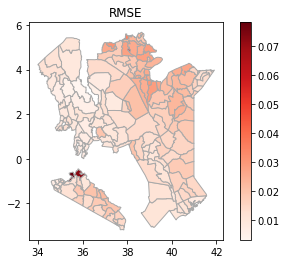

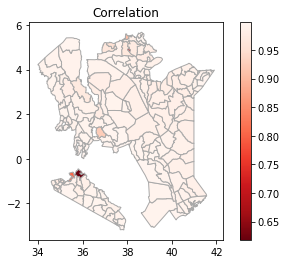

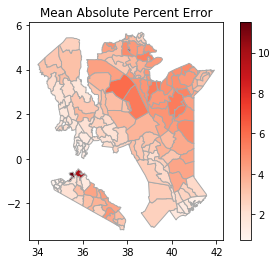

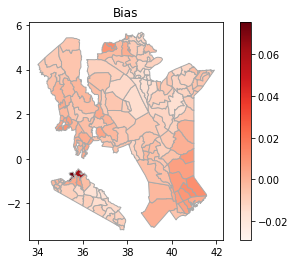

In [ ]:
#find RMSE and correlation
comparison = gpd.GeoDataFrame()
columnlist = ['avg1', 'avg2', 'avg3', 'avg4', 'avg5', 'avg6', 'avg7', 'avg8', 'avg9', 'avg10', 'avg11', 'avg12']

comparison['rmse'] = np.sqrt(((smodisdf[columnlist]-emodisdf[columnlist])**2).mean(axis=1)) #find rmse per uai
comparison['correlation'] = smodisdf[columnlist].corrwith(emodisdf[columnlist], axis = 1, method='pearson')


#find mean absolute percent error
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean((np.abs((y_true - y_pred) / y_true)) * 100, axis=1)

comparison['MAPE'] = mean_absolute_percentage_error(emodisdf[columnlist], smodisdf[columnlist])

#calculate bias
comparison['Bias'] = (smodisdf[columnlist]-emodisdf[columnlist]).mean(axis = 1)

#set geometry and plot
comparison['geometry'] = map(lambda s: shape(s), emodisdf.geometry)
comparison.plot(column='rmse', cmap='Reds', legend=True, edgecolor='#a9a9a9').set_title('RMSE')
comparison.plot(column='correlation', cmap='Reds_r', legend=True, edgecolor='#a9a9a9').set_title('Correlation')
comparison.plot(column='MAPE', cmap='Reds', legend=True, edgecolor='#a9a9a9').set_title("Mean Absolute Percent Error")
comparison.plot(column='Bias', cmap='Reds', legend=True, edgecolor='#a9a9a9').set_title("Bias")

#download dataframe as csv
#must be using a Google Chrome browser for this to work
comparison.to_csv('monthlystats.csv')
#files.download('monthlystats.csv')

In [ ]:
smodis1 = smodisdf.drop(columns=['geometry']).transpose()
emodis1 = emodisdf.drop(columns=['geometry']).transpose()


df=pd.DataFrame()

for column in smodis1:
  slope, intercept, r_value, p_value, std_err = ss.linregress(emodis1[column], smodis1[column])
  if p_value>0.01:
    print(column, r_value, p_value)



(205, 0.7027671700827818, 0.010803582525778531)
(184, 0.6182217250160426, 0.032141179181333454)
